# <font color='darkblue'>__02 · Document Model with MongoDB__</font>

**Ziele**
- Daten ins **Dokumentenmodell** importieren (JSONL + optional Likes aus CSV)
- Indizes erstellen
- Die fünf Kernfragen **Q1–Q5** mit Aggregation Pipelines lösen
- Optionale Window-Functions (MongoDB ≥ 5.0) für Rolling-Trends

**Voraussetzungen**
- Laufender MongoDB-Server (lokal oder Atlas)
- Python: `pip install --user -U pymongo pandas matplotlib python-dateutil
- **Docker (optional)**, Schnellstart lokal:
  ```bash
  docker run -d -p 27017:27017 --name mongo mongo:6
  ```

**Ordnerstruktur (relativ zum Notebook)**
```
notebooks/
  02_mongodb.ipynb
  data/
    document/
      posts.jsonl
      users.jsonl
      follows.jsonl
    relational/
      likes.csv      # optional für 'likes_made'
```

**Kernfragen**
1. Aktivste Nutzer:innen (Posts/Kommentare/Likes) → Engagement Score  
2. Beliebteste Posts (Likes)  
3. Graph-Insights (Follower-/Following-Degree; *Shortest Path* via `$graphLookup` – bewusst limitiert)  
4. Trends über Zeit (Posts/Tag, 7d-Rolling mit `$setWindowFields` oder Pandas-Fallback)  
5. Feed-Abfrage (Posts der Gefolgten in den letzten X Tagen)


---

In [1]:
from dotenv import load_dotenv
load_dotenv()

# ## Setup
from pathlib import Path
import os, json, pandas as pd
from datetime import datetime, timedelta
from pymongo import MongoClient, ASCENDING, DESCENDING
from pymongo.errors import ServerSelectionTimeoutError
import matplotlib.pyplot as plt

# Relative Pfade
BASE = Path('.').resolve()
DOC = BASE / 'data' / 'document'
REL = BASE / 'data' / 'relational'

# MongoDB-Verbindung (Umgebungsvariable MONGO_URI respektieren)
MONGO_URI = os.environ.get('MONGO_URI', 'mongodb://localhost:27017')
DB_NAME = os.environ.get('MONGO_DB', 'workshop_mongo')

print('Notebook base:', BASE)
print('Document data path:', DOC)
print('Relational data path (optional likes.csv):', REL)
print('Mongo URI:', MONGO_URI, 'DB:', DB_NAME)

# Verbindung testen
client = MongoClient(MONGO_URI, serverSelectionTimeoutMS=3000)
try:
    info = client.server_info()
    print('MongoDB Version:', info.get('version'))
except ServerSelectionTimeoutError as e:
    raise SystemExit(f"Kann nicht mit MongoDB verbinden. Stelle sicher, dass ein Server läuft. Details: {e}")
    
db = client[DB_NAME]


C:\Users\pell\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Notebook base: C:\Users\pell\Documents\3__UNTERRICHT_STUDENTENBETREUUNG\MSc_WI\DataScience\HS25
Document data path: C:\Users\pell\Documents\3__UNTERRICHT_STUDENTENBETREUUNG\MSc_WI\DataScience\HS25\data\document
Relational data path (optional likes.csv): C:\Users\pell\Documents\3__UNTERRICHT_STUDENTENBETREUUNG\MSc_WI\DataScience\HS25\data\relational
Mongo URI: mongodb://localhost:27017 DB: workshop_mongo
MongoDB Version: 7.0.1


In [2]:
# ## Helper: robuste DataFrame-Ausgabe
def show_df(df, n=10):
    """Versuche pretty-display; wenn die Pandas-Repräsentation in der Umgebung fehlt,
    weiche auf JSON-Print aus, damit das Notebook überall läuft."""
    try:
        from IPython.display import display
        display(df.head(n))
    except Exception as e:
        try:
            print(df.head(n).to_json(orient='records'))
        except Exception as e2:
            print("Display-Fallback fehlgeschlagen:", e, "|", e2)


In [3]:
# ## Import: JSONL-Dokumente & optionale Likes
# Collections: users, posts, follows, likes (optional)

def import_jsonl(path: Path, coll_name: str, transform=None):
    coll = db[coll_name]
    # Nur neu laden, wenn leer – einfache Idempotenz
    if coll.estimated_document_count() == 0:
        print(f'Import {coll_name} from', path)
        with open(path, 'r', encoding='utf-8') as f:
            batch = []
            for line in f:
                doc = json.loads(line)
                if transform:
                    doc = transform(doc)
                batch.append(doc)
                if len(batch) >= 5000:
                    coll.insert_many(batch)
                    batch = []
            if batch:
                coll.insert_many(batch)
    else:
        print(f'Collection {coll_name} enthält bereits Daten (skip import).')
    return db[coll_name]

# Transform: created_at/since als echte Dates ablegen, wenn string
def parse_dates_generic(doc, fields):
    for fld in fields:
        if fld in doc and isinstance(doc[fld], str):
            try:
                doc[fld] = pd.to_datetime(doc[fld]).to_pydatetime()
            except Exception:
                pass
    return doc

# Users
users_coll = import_jsonl(DOC / 'users.jsonl', 'users', lambda d: parse_dates_generic(d, ['created_at']))

# Follows
follows_coll = import_jsonl(DOC / 'follows.jsonl', 'follows', lambda d: parse_dates_generic(d, ['since']))

# Posts (mit embedded comments & like_count)
def transform_post(d):
    d = parse_dates_generic(d, ['created_at'])
    if 'comments' in d and isinstance(d['comments'], list):
        for c in d['comments']:
            parse_dates_generic(c, ['created_at'])
    return d

posts_coll = import_jsonl(DOC / 'posts.jsonl', 'posts', transform_post)

# Optional: likes.csv als Collection laden (für 'likes_made')
likes_csv = REL / 'likes.csv'
if likes_csv.exists():
    if db['likes'].estimated_document_count() == 0:
        print('Import likes from CSV:', likes_csv)
        likes_df = pd.read_csv(likes_csv, parse_dates=['created_at'])
        # Workaround: statt to_dict('records') -> to_json + json.loads (+ Datetime-Parse)
        records = json.loads(likes_df.to_json(orient='records', date_format='iso'))
        try:
            from dateutil.parser import isoparse
            for r in records:
                if 'created_at' in r and isinstance(r['created_at'], str):
                    try:
                        r['created_at'] = isoparse(r['created_at'])
                    except Exception:
                        pass
        except Exception:
            pass
        db['likes'].insert_many(records)
    else:
        print('Collection likes enthält bereits Daten (skip import).')
else:
    print('Hinweis: likes.csv nicht gefunden – Q1 wird likes_made ggf. ohne Likes berechnen.')

# Indizes
users_coll.create_index([('user_id', ASCENDING)], unique=True)
follows_coll.create_index([('src_user_id', ASCENDING)])
follows_coll.create_index([('dst_user_id', ASCENDING)])
posts_coll.create_index([('author_id', ASCENDING), ('created_at', DESCENDING)])
posts_coll.create_index([('like_count', DESCENDING)])
if 'likes' in db.list_collection_names():
    db['likes'].create_index([('user_id', ASCENDING)])
    db['likes'].create_index([('post_id', ASCENDING)])


Collection users enthält bereits Daten (skip import).
Collection follows enthält bereits Daten (skip import).
Collection posts enthält bereits Daten (skip import).
Collection likes enthält bereits Daten (skip import).


## Q1 · Aktivste Nutzer:innen (Engagement)

**Definition**
- `posts_count` = Anzahl Posts pro Nutzer (`posts.author_id`)
- `comments_made` = Anzahl verfasster Kommentare (aus embedded `posts.comments.user_id` via `$unwind`)
- `likes_made` = Anzahl gegebener Likes (falls `likes` Collection vorhanden)
- `engagement_score` = Summe der drei

**Hinweis:** Wir nutzen `$unionWith`, um die drei Teilmengen in **einem** Aggregat zu kombinieren.


In [4]:
import pandas as pd

has_likes = 'likes' in db.list_collection_names()

# Pipeline A: posts_count
pipeline_posts = [
    {'$group': {'_id': '$author_id', 'posts_count': {'$sum': 1}, 'comments_made': {'$sum': 0}, 'likes_made': {'$sum': 0}}}
]

# Pipeline B: comments_made
pipeline_comments = [
    {'$unwind': '$comments'},
    {'$group': {'_id': '$comments.user_id', 'posts_count': {'$sum': 0}, 'comments_made': {'$sum': 1}, 'likes_made': {'$sum': 0}}}
]

agg = db['posts'].aggregate(
    [
        *pipeline_posts,
        {'$unionWith': {'coll': 'posts', 'pipeline': pipeline_comments}},
    ] + (
        [{'$unionWith': {'coll': 'likes', 'pipeline': [
            {'$group': {'_id': '$user_id', 'posts_count': {'$sum': 0}, 'comments_made': {'$sum': 0}, 'likes_made': {'$sum': 1}}}
        ]}}] if has_likes else []
    ) + [
        {'$group': {'_id': '$_id',
                    'posts_count': {'$sum': '$posts_count'},
                    'comments_made': {'$sum': '$comments_made'},
                    'likes_made': {'$sum': '$likes_made'}}},
        {'$addFields': {'engagement_score': {'$add': ['$posts_count', '$comments_made', '$likes_made']}}},
        {'$lookup': {
            'from': 'users',
            'let': {'uid': '$_id'},
            'pipeline': [{'$match': {'$expr': {'$eq': ['$user_id', '$$uid']}}},
                         {'$project': {'_id': 0, 'username': 1}}],
            'as': 'user'}},
        {'$set': {'username': {'$ifNull': [{'$arrayElemAt': ['$user.username', 0]}, None]}}},
        {'$project': {'user': 0}},
        {'$sort': {'engagement_score': -1, 'posts_count': -1}},
        {'$limit': 20}
    ]
)

df_q1 = pd.DataFrame(list(agg)).rename(columns={'_id': 'user_id'})
show_df(df_q1, 10)


,user_id,posts_count,comments_made,likes_made,engagement_score,username
0,107,10,5,11,26,user_nmcbli
1,94,10,4,12,26,user_ethptp
2,35,5,6,14,25,user_eycepr
3,11,8,4,12,24,user_kbxosf
4,156,10,6,7,23,user_muncny
5,43,9,3,11,23,user_rwngxb
6,104,7,7,9,23,user_yuqryl
7,15,12,2,8,22,user_kpmgoy
8,198,9,3,10,22,user_aitdje
9,138,4,6,12,22,user_qxqilp


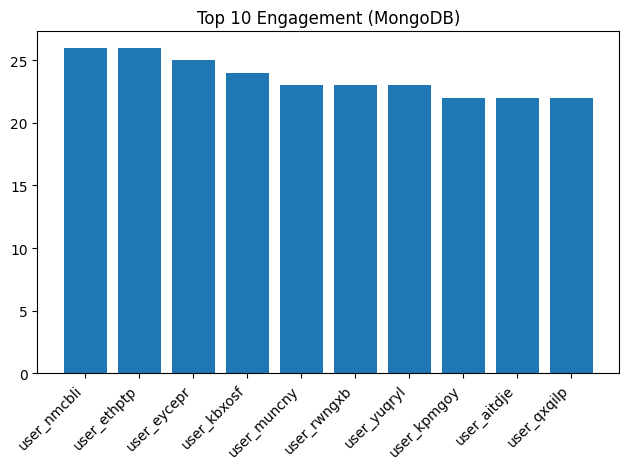

In [5]:
# Visualisierung Top-10 Engagement
top10 = df_q1.head(10)
plt.figure()
plt.bar(top10['username'].fillna(top10['user_id'].astype(str)), top10['engagement_score'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Engagement (MongoDB)')
plt.tight_layout()


## Q2 · Beliebteste Posts (Likes)
Posts besitzen im Dokumentmodell bereits `like_count`. Wir reichern die Ausgabe mit Autor:in an.


In [6]:
import pandas as pd
pipeline = [
    {'$sort': {'like_count': -1, '_id': 1}},
    {'$limit': 20},
    {'$lookup': {
        'from': 'users',
        'let': {'aid': '$author_id'},
        'pipeline': [{'$match': {'$expr': {'$eq': ['$user_id', '$$aid']}}},
                     {'$project': {'_id': 0, 'username': 1}}],
        'as': 'author'
    }},
    {'$set': {'author': {'$arrayElemAt': ['$author.username', 0]}}},
    {'$project': {'post_id': '$_id', 'author': 1, 'created_at': 1,
                  'like_count': 1, 'preview': {'$concat': [{'$substrCP': ['$text', 0, 80]}, '…']}}}
]
df_q2 = pd.DataFrame(list(db['posts'].aggregate(pipeline)))
show_df(df_q2, 10)


,_id,created_at,like_count,author,post_id,preview
0,136,2025-08-16,4,user_ywemfk,136,Sqlite ai trend sqlite post.…
1,138,2025-08-26,4,user_ywemfk,138,Cloud ai social coffee trend post social post ...
2,184,2025-08-13,4,user_nroycw,184,Data tinyflux social ai nlp sqlite.…
3,291,2025-08-26,4,user_djdfki,291,Tinyflux post cloud neo4j social ai tinyflux n...
4,292,2025-09-05,4,user_djdfki,292,Ml post coffee like post sql data follow pytho...
5,293,2025-08-26,4,user_djdfki,293,Trend follow mongodb nlp mongodb follow cloud ...
6,336,2025-08-31,4,user_zjquqt,336,Cloud post post follow music cloud graph ai ti...
7,381,2025-08-23,4,user_iwshay,381,Sql ai sqlite sql sqlite post post.…
8,384,2025-08-15,4,user_gkogms,384,Sql cloud graph ml coffee cloud nlp data.…
9,386,2025-09-10,4,user_ucfrhp,386,Graph follow neo4j follow sqlite sqlite follow...


## Q3 · Graph-Insights in MongoDB
- **Degrees**: via `$lookup` + `$count` pro Richtung
- **Shortest Path**: Demo mit `$graphLookup` (beschränkt) – in Neo4j einfacher/natürlicher


In [7]:
import pandas as pd
pipeline = [
    {'$lookup': {
        'from': 'follows',
        'let': {'uid': '$user_id'},
        'pipeline': [{'$match': {'$expr': {'$eq': ['$dst_user_id', '$$uid']}}},
                     {'$count': 'followers'}],
        'as': 'f1'}},
    {'$lookup': {
        'from': 'follows',
        'let': {'uid': '$user_id'},
        'pipeline': [{'$match': {'$expr': {'$eq': ['$src_user_id', '$$uid']}}},
                     {'$count': 'following'}],
        'as': 'f2'}},
    {'$set': {
        'followers': {'$ifNull': [{'$arrayElemAt': ['$f1.followers', 0]}, 0]},
        'following': {'$ifNull': [{'$arrayElemAt': ['$f2.following', 0]}, 0]}
    }},
    {'$project': {'_id': 0, 'user_id': 1, 'username': 1, 'followers': 1, 'following': 1}},
    {'$sort': {'followers': -1, 'following': -1}},
    {'$limit': 20}
]
df_deg = pd.DataFrame(list(db['users'].aggregate(pipeline)))
show_df(df_deg, 10)


,user_id,username,followers,following
0,80,user_mgjpzs,27,23
1,90,user_gkogms,25,23
2,98,user_cbmprd,25,23
3,141,user_ticzdz,25,5
4,154,user_oucwdj,24,25
5,41,user_nroycw,22,22
6,71,user_kfkxps,22,22
7,108,user_afrwpa,22,22
8,91,user_ucfrhp,22,9
9,10,user_rfitbv,21,22


In [8]:
# Kürzeste Pfad-Demo via $graphLookup (maxDepth 5). Dies ist limitiert und dient als Vergleich zu Neo4j.
import random

# zwei zufällige, verschiedene Nutzer
uids = list(db['users'].find({}, {'user_id': 1, '_id': 0}))
src, dst = random.sample([u['user_id'] for u in uids], 2)
print('Quelle:', src, 'Ziel:', dst)

pipeline = [
    {'$match': {'src_user_id': src}},
    {'$graphLookup': {
        'from': 'follows',
        'startWith': '$dst_user_id',
        'connectFromField': 'dst_user_id',
        'connectToField': 'src_user_id',
        'as': 'paths',
        'maxDepth': 5,
        'depthField': 'depth'
    }},
    {'$project': {
        '_id': 0,
        'reachable': {
            '$map': {
                'input': '$paths',
                'as': 'p',
                'in': {'uid': '$$p.dst_user_id', 'depth': '$$p.depth'}
            }
        }
    }},
    {'$unwind': '$reachable'},
    {'$match': {'reachable.uid': dst}},
    {'$sort': {'reachable.depth': 1}},
    {'$limit': 1}
]

res = list(db['follows'].aggregate(pipeline))
if res:
    print('Pfad gefunden bis Tiefe:', res[0]['reachable']['depth'])
else:
    print('Kein Pfad bis maxDepth gefunden (oder $graphLookup limitiert)')


Quelle: 58 Ziel: 49
Pfad gefunden bis Tiefe: 0


## Q4 · Trends über Zeit (Posts/Tag, 7d-Rolling)
Wir versuchen zuerst eine reine MongoDB-Lösung mit `$setWindowFields` (MongoDB ≥ 5.0).  
Falls nicht verfügbar, nutzen wir einen **Pandas-Fallback**.


In [9]:
import pandas as pd

# 1) Check MongoDB Version
version = tuple(int(x) for x in client.server_info().get('version').split('.')[:2])
supports_window = version >= (5,0)
print('Mongo Window Functions verfügbar:', supports_window)

# 2) Aggregation: Posts pro Tag
if supports_window:
    pipeline = [
        {'$project': {'day': {'$dateTrunc': {'date': '$created_at', 'unit': 'day'}}}},
        {'$group': {'_id': '$day', 'posts': {'$sum': 1}}},
        {'$sort': {'_id': 1}},
        {'$setWindowFields': {
            'sortBy': {'_id': 1},
            'output': {
                'rolling_7d': {
                    '$avg': '$posts',
                    'window': {'range': [-6, 0], 'unit': 'day'}
                }
            }
        }},
        {'$project': {'day': '$_id', 'posts': 1, 'rolling_7d': 1, '_id': 0}}
    ]
    df_trend = pd.DataFrame(list(db['posts'].aggregate(pipeline)))
else:
    # Fallback: Hole Tagescounts und berechne Rolling in Pandas
    pipeline = [
        {'$project': {'day': {'$dateTrunc': {'date': '$created_at', 'unit': 'day'}}}},
        {'$group': {'_id': '$day', 'posts': {'$sum': 1}}},
        {'$sort': {'_id': 1}},
        {'$project': {'day': '$_id', 'posts': 1, '_id': 0}}
    ]
    df_trend = pd.DataFrame(list(db['posts'].aggregate(pipeline)))
    df_trend['rolling_7d'] = df_trend['posts'].rolling(7, min_periods=1).mean()

show_df(df_trend, 10)


Mongo Window Functions verfügbar: True


,posts,rolling_7d,day
0,22,22.000000,2025-08-12
1,24,23.000000,2025-08-13
2,31,25.666667,2025-08-14
3,39,29.000000,2025-08-15
4,31,29.400000,2025-08-16
5,28,29.166667,2025-08-17
6,38,30.428571,2025-08-18
7,23,30.571429,2025-08-19
8,29,31.285714,2025-08-20
9,30,31.142857,2025-08-21


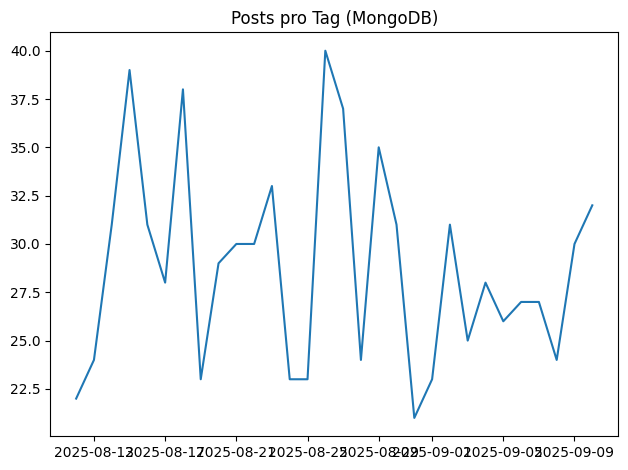

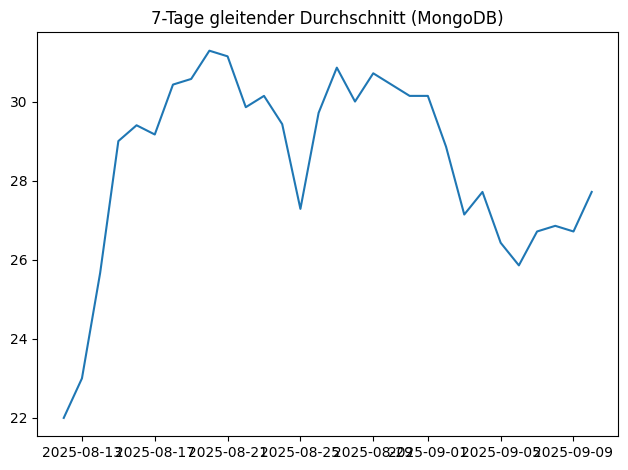

In [10]:
# Plot
plt.figure()
plt.plot(pd.to_datetime(df_trend['day']), df_trend['posts'])
plt.title('Posts pro Tag (MongoDB)')
plt.tight_layout()

plt.figure()
plt.plot(pd.to_datetime(df_trend['day']), df_trend['rolling_7d'])
plt.title('7-Tage gleitender Durchschnitt (MongoDB)')
plt.tight_layout()


## Q5 · Feed-Abfrage (Posts der Gefolgten in den letzten X Tagen)

**Parameter**
- `viewer_user_id`: Nutzer, für den wir den Feed berechnen
- `days_back`: Zeitfenster (in Tagen)


In [11]:
from datetime import datetime, timedelta
import pandas as pd

viewer_user_id = 1
days_back = 3

# 1) Folge-Liste holen
followings = [d['dst_user_id'] for d in db['follows'].find({'src_user_id': viewer_user_id}, {'dst_user_id': 1, '_id': 0})]
since = datetime.utcnow().date() - timedelta(days=days_back)

# 2) Posts dieser Autor:innen seit 'since'
pipeline = [
    {'$match': {'author_id': {'$in': followings}, 'created_at': {'$gte': pd.to_datetime(since).to_pydatetime()}}},
    {'$lookup': {
        'from': 'users',
        'let': {'aid': '$author_id'},
        'pipeline': [{'$match': {'$expr': {'$eq': ['$user_id', '$$aid']}}},
                     {'$project': {'_id': 0, 'username': 1}}],
        'as': 'author'
    }},
    {'$set': {'author': {'$arrayElemAt': ['$author.username', 0]}}},
    {'$project': {'post_id': '$_id', 'author': 1, 'created_at': 1, 'like_count': 1,
                  'preview': {'$concat': [{'$substrCP': ['$text', 0, 100]}, '…']}}},
    {'$sort': {'created_at': -1}},
    {'$limit': 50}
]
df_feed = pd.DataFrame(list(db['posts'].aggregate(pipeline)))
show_df(df_feed, 20)


,_id,created_at,like_count,author,post_id,preview
0,23,2025-09-10,2,user_jigbld,23,Mongodb sqlite nlp neo4j cloud social coffee s...
1,399,2025-09-10,0,user_ethptp,399,Cloud neo4j graph ml python like.…
2,204,2025-09-09,3,user_lhauqg,204,Mongodb social mongodb mongodb graph follow tr...
3,396,2025-09-08,0,user_ethptp,396,Social like neo4j graph tinyflux python.…


## Zusammenfassung (Dokumentenmodell · MongoDB)

**Stärken**
- Flexible Schemata (Kommentare eingebettet → einfache Lesezugriffe „Post + Kommentare in *einem* Dokument“)
- Aggregation Pipeline ist ausdrucksstark; `$lookup` und `$unionWith` vermeiden oft Client-Seitiges Joinen
- `$graphLookup` ermöglicht begrenzte Traversals; `$setWindowFields` (≥5.0) erlaubt Rolling/Window-Analysen

**Schwächen (Use-Case-spezifisch)**
- Komplexe Graph-Algorithmen (kürzeste Pfade, Communities) sind umständlich im Vergleich zu Neo4j
- Strikte Konsistenz/Transaktionen wie in RDBMS sind möglich, aber operativ anders gelagert
- Modellierungsentscheidungen (embed vs. reference) beeinflussen Queries stark

**Merksatz**
> Dokumentenmodelle sind *ideal* für inhaltsnahe, flexible Strukturen und schnelle Lesezugriffe –
> für tiefe Graph-Analysen oder stark normalisierte Konsistenzfälle sind spezialisierte Modelle oft besser.
